In [2]:
import pandas as pd
from sklearn import preprocessing as process
from sklearn.model_selection import ShuffleSplit
import keras as k
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Quick Look at the Feature Data

Most of the fields are quantities, save for the Job number and the Company. Job numbers increment in value, so the highest number jobs are the most recent. For now we will exclude those two categories.

In [4]:
df = pd.read_csv('data/features.csv', encoding='utf-8')
df = df[df.Company == 'HEM']  # drop SMC data?
del df['Company']
del df['JobNum']

In [5]:
df.head()

,SchedDays,OpCount,TotalProdHours,TotalSetupHours,TotalSubLeadTime,TotalSubCost,TotalSubContractOps,ActDays
0,26.0,14.0,21.04,2.55,11.0,0.49593,3.0,45
1,44.0,12.0,9.25,3.50,29.0,7.99764,4.0,42
2,33.0,13.0,36.47,10.25,3.0,0.00000,1.0,43
3,23.0,7.0,16.41,2.84,8.0,12.74412,2.0,14
4,16.0,4.0,3.50,0.00,10.0,0.35000,1.0,10


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2754 entries, 0 to 3057
Data columns (total 8 columns):
SchedDays              2754 non-null float64
OpCount                2754 non-null float64
TotalProdHours         2754 non-null float64
TotalSetupHours        2754 non-null float64
TotalSubLeadTime       2754 non-null float64
TotalSubCost           2754 non-null float64
TotalSubContractOps    2754 non-null float64
ActDays                2754 non-null int64
dtypes: float64(7), int64(1)
memory usage: 193.6 KB


In [9]:
df.describe()

,SchedDays,OpCount,TotalProdHours,TotalSetupHours,TotalSubLeadTime,TotalSubCost,TotalSubContractOps,ActDays
count,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000
mean,26.669392,6.771419,28.926717,2.416861,10.359120,4.753153,1.256704,25.922171
std,41.510981,4.196328,109.980114,3.155894,22.692434,19.675606,1.319377,28.890810
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,3.000000,3.285000,0.500000,0.000000,0.000000,0.000000,4.000000
50%,17.000000,6.000000,8.670000,2.000000,5.000000,0.024250,1.000000,16.000000
75%,33.000000,9.000000,22.685000,3.197500,13.000000,1.981870,2.000000,39.000000
max,980.000000,32.000000,3939.110000,102.000000,535.000000,594.676900,10.000000,292.000000


### Split And Standardize and Transform The Data
Standard Scaler brings the mean to 0 and the standard deviation to 1. Quantile Transformer shifts the distribution to look more gaussian, smoothing out unusual distributions and is less influenced by outliers than scaling methods. It does, however, distort correlations and distances within and across features

In [94]:
from sklearn.externals import joblib

# 80% of the samples will be used for training
m = np.floor(df.shape[0] * 0.8).astype('int')

# Processing X: standardize feature values
X = df.iloc[:m, :-1].values
x_test = df.iloc[m:, :-1].values

scale = process \
    .StandardScaler() \
    .fit(X)

joblib.dump(scale, 'app/scaler.pkl')  # saving the transformation for deployed system

X = scale.transform(X)
x_test = scale.transform(x_test)

# Processing Y: to categories by week (over 25 weeks aka 6 months are just grouped together)
Y = df.iloc[:m, -1:].apply(lambda x: np.where(x // 5 < 25, x // 5, 25)).values
Y = k.utils.to_categorical(Y, num_classes=26)

y_test = df.iloc[m:, -1:].apply(lambda x: np.where(x // 5 < 25, x // 5, 25)).values
y_test = k.utils.to_categorical(y_test, num_classes=26)


#### NOT USED ###############
# Log shift data to get a gaussian distribution for each feature
shift = process \
    .QuantileTransformer(random_state=0) \
    .fit(X)

# Shuffling function for k-folds (model.train_on_batch)
ss = ShuffleSplit(n_splits=5, 
                  test_size=0.25, 
                  random_state=0)

def preprocess(x):
#     x = scale.transform(x)
    x = shift.transform(x)
    return x
#### NOT USED ###############

### Model Architecture And Training

In [95]:
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers

I = Input(shape=(7,))
H = Dense(24, activation='tanh')(I)
O = Dense(26, activation='softmax', activity_regularizer=regularizers.l2(0.01))(H)

model = Model(inputs=I, outputs=O)
model.compile(optimizer='sgd', loss='categorical_crossentropy')

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                192       
_________________________________________________________________
dense_8 (Dense)              (None, 26)                650       
Total params: 842
Trainable params: 842
Non-trainable params: 0
_________________________________________________________________


In [97]:
Y.shape

(2203, 26)

### Train Baseline Model

In [98]:
from keras import optimizers
from keras import metrics

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model = Model(inputs=I, outputs=O)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[metrics.categorical_accuracy])
hist = model.fit(X,Y, validation_split=0.2, epochs=50, batch_size=5, verbose=0)


### Visualize Training

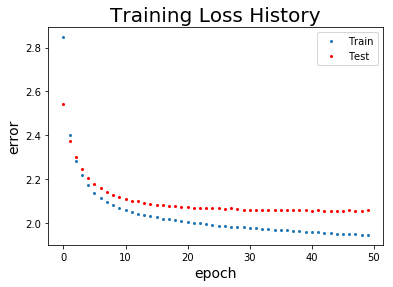

In [110]:
import matplotlib.pyplot as plt
plt.gca().set_title('Training Loss History', size=20)
plt.gca().set_ylabel('error', size=14)
plt.gca().set_xlabel('epoch', size=14)
plt.plot(hist.history['loss'], 'o', markersize=2, label='Train')
plt.plot(hist.history['val_loss'], 'ro', markersize=2, label='Test')
plt.legend();

### Continue Training

In [100]:
from keras import backend as K
K.set_value(model.optimizer.lr, 0.0005)
new_hist = model.fit(X,Y, validation_split=0.2, epochs=20, batch_size=10, verbose=0)

### Check Prediction Abilities

In [102]:
# Convert business-week categories to business days
pred = np.argmax(model.predict(x_test), axis=1) * 5 + 5
act = np.argmax(y_test, axis=1) * 5 + 5

# calculate Mean Absolute Error
mae = np.sum(np.abs(pred - act)) / x_test.shape[0]
print("Model predicts with a {0:.0f} business day average lead time error".format(mae))

Model predicts with a 11 business day average lead time error


### Save Model

In [103]:
import json
with open('app/model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)
    
model.save_weights('app/weights.h5')

### Load Model

In [104]:
from keras.models import model_from_json

with open('app/model.json') as json_data:
    json_string = json.load(json_data)
    model_v2 = model_from_json(json_string)
    
model_v2.load_weights('app/weights.h5')

### Double Check Prediction Capabilities

In [105]:
# Convert business-week categories to business days
pred = np.argmax(model_v2.predict(x_test), axis=1) * 5 + 5
act = np.argmax(y_test, axis=1) * 5 + 5

# calculate Mean Absolute Error
mae = np.sum(np.abs(pred - act)) / x_test.shape[0]
print("Model predicts with a {0:.0f} business day average lead time error".format(mae))

Model predicts with a 11 business day average lead time error
